In [793]:
import math
import pandas as pd
import argparse

In [794]:
# Constants

case = {
    1: {'name': "Deep Swale",
        'n': 0.013,
        'b': 0.15,
        'z': 0.225/0.300,
        },
    2: {'name': "Gravel Lane",
        'n': 0.022,
        'b': 0,
        'z': 1/0.035,
        },
    3: {'name': "Circular Pipe (PVC)",
        'n': 0.011,
        },
    4: {'name': "Circular Pipe (Concrete)",
        'n': 0.013,
        },
    5: {'name': "Road",
        'n': 0.013,
        'curb': {
            'std': {
                'curb_face_height': 0.14,
                'curb_face_depth': 0.015,
                'curb_top_width': 0.150,
                'gutter_depth': 0.025,
                'gutter_width': 0.25,
            },
            'rolled': {
                'curb_face_height': 0.100,
                'curb_face_depth': 0.550 - 0.250 - 0.025 - 0.024,
                'curb_top_width': 0.024,
                'gutter_depth': 0.025,
                'gutter_width': 0.25,
            }, }
        },
}

# Trapezoidal Cross Section

To find the depth of flow in a trapezoidal channel using Manning’s equation, you need to use the following steps and formulas:

1. **Manning’s Equation**:

    $ Q = \frac{1}{n} A R^{2/3} S^{1/2} $

    Where:

    - $ Q $ = flow rate (m³/s)
    - $ n $ = Manning’s roughness coefficient
    - $ A $ = cross-sectional area of flow (m²)
    - $ R $ = hydraulic radius (m)
    - $ S $ = slope of the channel (%)

2. **Cross-Sectional Area for a Trapezoidal Channel**:

    $A = (b + zy) y$

    Where:

    - $ b $ = bottom width of the channel (m)
    - $ z $ = side slope (horizontal distance per unit vertical distance)
    - $ y $ = depth of flow (m)

3. **Wetted Perimeter for a Trapezoidal Channel**:
   $ P = b + 2y \sqrt{1 + z^2} $

4. **Hydraulic Radius**:
   $ R = \frac{A}{P} $

To find the depth $ y $, follow these steps:

1. Express the cross-sectional area $ A $ and wetted perimeter $ P $ in terms of $ y $:
   $ A = \left(b + zy\right) y $
   $ P = b + 2y \sqrt{1 + z^2} $

2. Substitute these into the hydraulic radius formula:
   $ R = \frac{\left(b + zy\right) y}{b + 2y \sqrt{1 + z^2}} $

3. Substitute $ A $ and $ R $ into Manning’s equation:
   $ Q = \frac{1}{n} \left[\left(b + zy\right) y\right] \left[\frac{\left(b + zy\right) y}{b + 2y \sqrt{1 + z^2}}\right]^{2/3} S^{1/2} $

4. This results in an equation that must be solved iteratively or using numerical methods to find the depth $ y $.

Here procedure for the iterative solution:

1. Assume an initial depth $ y $.
2. Calculate $ A $ using $ A = \left(b + zy\right) y $.
3. Calculate $ P $ using $ P = b + 2y \sqrt{1 + z^2} $.
4. Calculate $ R $ using $ R = \frac{A}{P} $.
5. Substitute $ A $, $ R $, and $ S $ into Manning’s equation to solve for $ Q $.
6. Compare the calculated $ Q $ with the given flow rate.
7. Adjust $ y $ and repeat steps 2-6 until the calculated $ Q $ matches the given $ Q $ within an acceptable tolerance.


In [795]:
def manning_trapezoid(Q, n, b, z, S, y_min=0.001, y_max=10, tolerance=1e-6, max_iterations=1000):
    def calculate_flow(y):
        A = (b + z * y) * y
        P = b + 2 * y * math.sqrt(1 + z * z)
        R = A / P
        return (1 / n) * A * (R ** (2/3)) * (S ** 0.5), A

    low, high = y_min, y_max
    for _ in range(max_iterations):
        mid = (low + high) / 2
        Q_mid, A = calculate_flow(mid)

        if abs(Q_mid - Q) < tolerance:
            return mid, A
        elif Q_mid < Q:
            low = mid
        else:
            high = mid
    raise ValueError(
        f"Solution did not converge within {max_iterations} iterations")

# Circular Cross Section

To find the depth of flow in a circular pipe using Manning’s equation, follow these steps and formulas:

1. **Manning’s Equation**:

    $ Q = \frac{1}{n} A R^{2/3} S^{1/2} $

    Where:

    - $ Q $ = flow rate (m³/s)
    - $ n $ = Manning’s roughness coefficient
    - $ A $ = cross-sectional area of flow (m²)
    - $ R $ = hydraulic radius (m)
    - $ S $ = slope of the pipe (%)

2. **Cross-Sectional Area for a Circular Pipe**:

    $ A = r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2} $

    Where:

    - $ r $ = radius of the pipe (m)
    - $ h $ = depth of flow (m)

3. **Wetted Perimeter for a Circular Pipe**:

    $ P = r \theta $

    Where:

    - $ \theta $ is the central angle in radians, calculated as $ \theta = 2 \cos^{-1} \left( \frac{r-h}{r} \right) $

4. **Hydraulic Radius**:

    $ R = \frac{A}{P} $

To find the depth $ h $, follow these steps:

1. **Express the cross-sectional area $ A $ and wetted perimeter $ P $ in terms of $ h $**:
   $ A = r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2} $
   $ P = r \theta $
   Where $ \theta = 2 \cos^{-1} \left( \frac{r-h}{r} \right) $

2. **Substitute these into the hydraulic radius formula**:
   $ R = \frac{r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2}}{r \theta} $

3. **Substitute $ A $ and $ R $ into Manning’s equation**:
   $ Q = \frac{1}{n} \left[ r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2} \right] \left[ \frac{r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2}}{r \theta} \right]^{2/3} S^{1/2} $

4. **This results in an equation that must be solved iteratively or using numerical methods to find the depth $ h $**.

### Procedure for the Iterative Solution:

1. Assume an initial depth $ h $.
2. Calculate $ A $ using $ A = r^2 \cos^{-1} \left( \frac{r-h}{r} \right) - (r-h) \sqrt{2rh - h^2} $.
3. Calculate $ \theta $ using $ \theta = 2 \cos^{-1} \left( \frac{r-h}{r} \right) $.
4. Calculate $ P $ using $ P = r \theta $.
5. Calculate $ R $ using $ R = \frac{A}{P} $.
6. Substitute $ A $, $ R $, and $ S $ into Manning’s equation to solve for $ Q $.
7. Compare the calculated $ Q $ with the given flow rate.
8. Adjust $ h $ and repeat steps 2-7 until the calculated $ Q $ matches the given $ Q $ within an acceptable tolerance.


In [796]:
def manning_circular(Q, n, D, S, tolerance=1e-6, max_iterations=1000):
    def calculate_flow(h):
        r = D / 2
        A = r**2 * math.acos((r-h)/r) - (r - h) * math.sqrt(2*r*h-h**2)
        P = D * math.acos((r - h) / r)
        R = A / P
        return (1 / n) * A * (R ** (2/3)) * (S ** 0.5), A

    low, high = 0.001, D
    for _ in range(max_iterations):
        mid = (low + high) / 2
        Q_mid, A = calculate_flow(mid)

        if abs(Q_mid - Q) < tolerance:
            return mid, A
        elif Q_mid < Q:
            low = mid
        else:
            high = mid
    raise ValueError(
        f"Solution did not converge within {max_iterations} iterations")

# Road Cross Section


## Pavement Road Crowns


In [797]:
import numpy as np
from scipy.interpolate import griddata

# Define the grid
slope = np.array([0.6, 1.0, 2.0, 2.99999, 3, 3.99999, 4, 5, 5.99999,
                 6, 7, 8, 8.99999, 9, 10, 11, 12])
width = np.arange(8.5, 15.5, 0.5)

crown_data = np.array([
    [135, 145, 150, 160, 170, 175, 185, 190, 200, 210, 215, 225, 230, 240],
    [135, 145, 150, 160, 170, 175, 185, 190, 200, 210, 215, 225, 230, 240],
    [135, 145, 150, 160, 170, 175, 185, 190, 200, 210, 215, 225, 230, 240],
    [135, 145, 150, 160, 170, 175, 185, 190, 200, 210, 215, 225, 230, 240],
    [105, 115, 120, 125, 130, 140, 145, 150, 160, 165, 170, 175, 180, 190],
    [105, 115, 120, 125, 130, 140, 145, 150, 160, 165, 170, 175, 180, 190],
    [85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150],
    [85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150],
    [85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150],
    [65, 70, 70, 75, 80, 85, 85, 90, 95, 100, 100, 105, 110, 110],
    [65, 70, 70, 75, 80, 85, 85, 90, 95, 100, 100, 105, 110, 110],
    [65, 70, 70, 75, 80, 85, 85, 90, 95, 100, 100, 105, 110, 110],
    [65, 70, 70, 75, 80, 85, 85, 90, 95, 100, 100, 105, 110, 110],
    [50, 50, 55, 55, 60, 65, 65, 70, 70, 75, 75, 80, 85, 90],
    [50, 50, 55, 55, 60, 65, 65, 70, 70, 75, 75, 80, 85, 90],
    [50, 50, 55, 55, 60, 65, 65, 70, 70, 75, 75, 80, 85, 90],
    [50, 50, 55, 55, 60, 65, 65, 70, 70, 75, 75, 80, 85, 90],
])

# Flatten the grid points
points = np.array([(s, w) for s in slope for w in width])
values = crown_data.flatten()

# # Define the point to interpolate
# slope_interp = 3
# width_interp = 10

# # Perform the interpolation
# value_interp = griddata(points, values, (slope_interp,
#                         width_interp), method='linear')

# print(
#     f"Interpolated value at slope = {slope_interp}, width = {width_interp} is {value_interp}")

In [798]:
def calculate_road_crown(road_width=9, slope=0.03):
    Y = griddata(points, values, (slope * 100,
                                  road_width), method='linear')

    # Option 1 use quarter crown
    # quarter_crown = 0.75 * Y / 1000 / (road_width / 4)
    # return quarter_crown if not math.isnan(quarter_crown) else 0.02

    # Option 2 use average crown
    # result = Y / 1000 / road_width / 2
    # return result if not math.isnan(result) else 0.02

    # Option 3 2%
    return 0.02

## Calculate Road Area


In [799]:
def calculate_road_area(d, road_width=9, ROW=16, curb="std", road_slope=0.02, row_slope=0.02):
    # Constants
    curb_constants = case[5]['curb'][curb]
    curb_face_height = curb_constants['curb_face_height']
    curb_face_depth = curb_constants['curb_face_depth']
    curb_top_width = curb_constants['curb_top_width']
    gutter_depth = curb_constants['gutter_depth']
    gutter_width = curb_constants['gutter_width']

    gutter_slope = (gutter_depth / gutter_width)
    curb_slope = (curb_face_height / curb_face_depth)
    ROW_width = ROW / 2 - road_width / 2 - \
        gutter_width - curb_face_depth - curb_top_width

    # Calculate depth
    d_L1 = d_R1 = d_L2 = d_R2 = d_L3 = d_R3 = 0

    if d < gutter_depth:
        d_L1 = d
    else:
        d_L1 = gutter_depth

        if d < (road_width / 2 * road_slope) + gutter_depth:
            d_L2 = d - gutter_depth
        else:
            d_L2 = (road_width / 2 * road_slope)

            d_L3 = d - gutter_depth - (road_width / 2 * road_slope)
            if d_L3 < 0:
                d_L3 = 0

        if d < curb_face_height:
            d_R1 = d
        else:
            d_R1 = curb_face_height
            d_R2 = d - curb_face_height
            if d_R2 > (ROW_width * row_slope):
                # print(f"Depth of {d} m will fill entire ROW width. ")
                d_R2 = ROW_width * row_slope
                d_R3 = d - (ROW_width * row_slope) - curb_face_height

    # Calculate area
    A_L1 = d_L1 ** 2 / (2 * gutter_slope)  # triangle
    A_L2 = gutter_width * d_L2  # rectangle
    A_L3 = (d_L2 ** 2) / (2 * road_slope)  # triangle
    A_L4 = (road_width + gutter_width) * d_L3  # rectangle

    A_R1 = d_R1 ** 2 / (2 * curb_slope)  # triangle
    A_R2 = d_R2 * (curb_face_depth + curb_top_width)  # rectangle
    A_R3 = d_R2 ** 2 / (2 * row_slope)  # triangle
    A_R4 = d_R3 * ROW_width  # rectangle

    A = A_L1 + A_L2 + A_L3 + A_L4 + A_R1 + A_R2 + A_R3 + A_R4

    # Calculate wetted perimeter
    P_L1 = math.sqrt(d_L1**2 + (d_L1 / gutter_slope)**2)
    P_L2 = math.sqrt(d_L2**2 + (d_L2 / road_slope)**2)

    P_R1 = math.sqrt(d_R1**2 + (d_R1 / curb_slope)**2)
    P_R2 = curb_top_width if d > curb_face_height else 0
    P_R3 = math.sqrt(d_R2**2 + (d_R2 / row_slope)**2)

    P = P_L1 + P_L2 + P_R1 + P_R2 + P_R3

    return A * 2, P * 2

In [800]:
def manning_road(Q, n, S, w, row, curb, y_min=0.001, y_max=10, tolerance=1e-6, max_iterations=1000):

    def calculate_flow(d):
        A, P = calculate_road_area(d, w, row, curb, crown)
        R = A / P
        return (1 / n) * A * (R ** (2/3)) * (S ** 0.5), A

    low, high = y_min, y_max
    crown = calculate_road_crown(w, S)
    for _ in range(max_iterations):
        mid = (low + high) / 2
        Q_mid, A = calculate_flow(mid)

        if abs(Q_mid - Q) < tolerance:
            return mid, A, crown
        elif Q_mid < Q:
            low = mid
        else:
            high = mid
    raise ValueError(
        f"Solution did not converge within {max_iterations} iterations")

In [801]:
def calculate_depth(row):
    if row['Type'] == "Deep Swale":
        params = case[1]
        depth, area = manning_trapezoid(
            row['Peak Discharge'], params['n'], params['b'], params['z'], row['Slope']/100)
    elif row['Type'] == "Gravel Lane":
        params = case[2]
        depth, area = manning_trapezoid(
            row['Peak Discharge'], params['n'], params['b'], params['z'], row['Slope']/100)
    elif row['Type'] == "Circular Pipe (PVC)":
        params = case[3]
        D = float(row['Diameter'])
        depth, area = manning_circular(
            row['Peak Discharge'], params['n'], D, row['Slope']/100)
    elif row['Type'] == "Circular Pipe (Concrete)":
        params = case[4]
        D = float(row['Diameter'])
        depth, area = manning_circular(
            row['Peak Discharge'], params['n'], D, row['Slope']/100)
    elif row['Type'] == "Road":
        params = case[5]
        depth, area, crown = manning_road(
            row['Peak Discharge'], params['n'], row['Slope']/100, row['Road Width'], row['ROW'], row["Curb"])
    else:
        raise ValueError(f"Unknown type: {row['Type']}")
    return depth, area, crown if crown else None

In [802]:
def plot_graph(data):
    df = pd.DataFrame([[0.5, 0.8], [1.0, 0.32], [2.0, 0.21], [3.0, 0.09]], columns=[
        "Water Velocity", "Permissible Depth"])

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.plot(df["Water Velocity"], df["Permissible Depth"], color="black")
    plt.scatter(data['Flow Velocity'], data["Flow Depth"],
                marker="d", color='red')

    plt.xlabel("Velocity (m/s)")
    plt.ylabel("Depth (m)")

    plt.grid(color='grey', linestyle='-', linewidth=1)

    plt.xlim(left=0)
    plt.ylim((0, 1))

    plt.text(0.1, 0.35, "Acceptable")
    plt.text(2.1, 0.55, "Not Acceptable")

    plt.plot()

In [803]:
def main(input_file):
    data = pd.read_csv(input_file, header=0)

    data[['Flow Depth', 'Area', "Crown"]] = data.apply(
        lambda row: pd.Series(calculate_depth(row)), axis=1)

    data['Flow Velocity'] = data['Peak Discharge'] / data['Area']

    data.drop(['Area'], axis=1, inplace=True)

    # new_column_order = ['Location Number', 'Peak Discharge',
    # 'Slope', 'Location', 'Type', 'Flow Velocity', 'Flow Depth']

    # data = data[new_column_order]

    result_name = input_file.replace('.csv', '_results.csv')

    data.to_csv(result_name, index=False)
    plot_graph(data)

    print(f"Results saved to {result_name}")

Results saved to ./data_road_results.csv


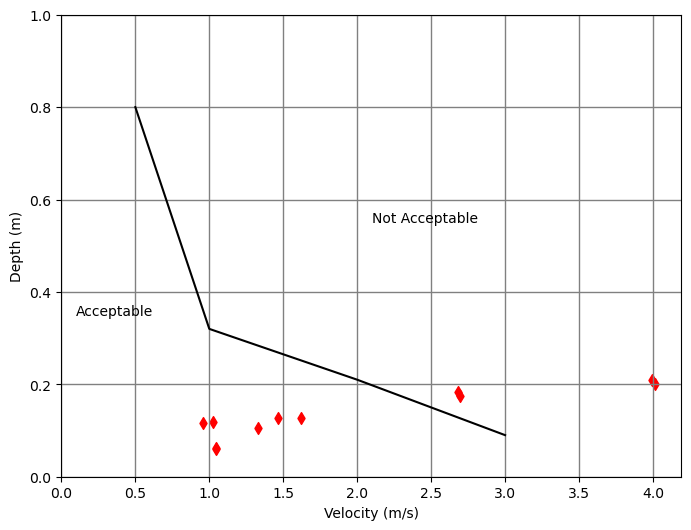

In [804]:
if __name__ == "__main__":
    # parser = argparse.ArgumentParser(
    #     description='Calculate depth and velocity for channels.')
    # parser.add_argument('input_file', type=str,
    #                     help='Path to the input CSV file')
    # args = parser.parse_args()

    # main(args.input_file)

    # main('./data_trapezoid.csv')
    # main('./data_circular.csv')
    main('./data_road.csv')